# AlexNet & CommonLoopUtils

In this example, we will implement [AlexNet](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) and also use [CommonLoopUtils](https://github.com/google/CommonLoopUtils) from Google to track the model training.

To follow along with this tutorial, you will need to run this pip install command:

```bash
pip install tensorflow_datasets tensorflow jaxtyping equinox clu tqdm matplotlib optax
```

## Short (and skippable) Introduction

AlexNet is a CNN model from 2012, which arguably brought the "deep" to deep learning. It trained on ImageNet, which is a massive dataset consisting of over 15 million images and over 22000 classes and before AlexNet, that dataset was a tough nut to crack! To solve that dataset, the authors brought a few novelties to the table, some of which we will skip. Those were:

- Using ReLU (instead of Sigmoid), which boosted performance, speed and addressed the vanishing gradient problem
- Multi GPU training (we will skip this, but they wrote a bunch of custom CUDA code to train the whole thing on TWO whole GPUs! Outrageous at that time)
- Local Response Normalisation (largely superseded by Batch Normalisation these days, but still interesting)
- Overlapping Max Pooling (basically using a stride of 2 instead of 1)
- Dropout to prevent overfitting
- a bunch of data augmentation:
    - crop the image to 256x256
    - select random 224x224 portion of the cropped image (we will do something similar)
    - randomly flip the image horizontally
    - PCA colour augmentation

None of these were solely their invention (except for the normalisation method and the multi GPU stuff) but the combination of all these techniques is what wrote history. 

In this example, though, we won't be training on the ImageNet dataset, but instead on the `cats_vs_dogs` dataset, which is much harder than MNIST, but still small enough that you can train the thing in a relatively short amount of time (~30 minutes on a 3090).

## Getting the Data

In this first section, we will load the dataset using `tensorflow_datasets`, preprocess the data a bit and finally have a ready-to-use dataset in Numpy. First, we import everything.

In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import jaxtyping as jt
import matplotlib.pyplot as plt
import optax
import tensorflow as tf
import tensorflow_datasets as tfds
from clu import metrics
from tqdm import tqdm

In [2]:
(train_dataset, test_dataset), info = tfds.load(
    "cats_vs_dogs",
    split=("train[:80%]", "train[80%:]"),
    with_info=True,
    as_supervised=True,
)  # pyright:ignore

print(info)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/Users/arturgalstyan/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howel

Lovely. The dataset is around 1.04 GiB! Let's preprocess this data by normalising and resizing the images. We will also shuffle the data around. The `SHUFFLE_VAL` is purposefully chosen to be smaller (hence the `/1000` part) because otherwise it might entirely fill your memory. The `tf.data.AUTOTUNE` part we can safely ignore. It's just for TensorFlow to do things more efficiently under the hood. 

In [3]:
def normalize(
    image: jt.Float[tf.Tensor, "h w c"], label: jt.Int[tf.Tensor, ""]
) -> tuple[jt.Float[tf.Tensor, "h w c"], jt.Int[tf.Tensor, ""]]:
    image = tf.divide(tf.cast(image, tf.float32), 255.0)
    assert isinstance(image, tf.Tensor)
    return image, label


def resize(
    image: jt.Float[tf.Tensor, "h w c"], label: jt.Int[tf.Tensor, ""]
) -> tuple[jt.Float[tf.Tensor, "c h w"], jt.Int[tf.Tensor, ""]]:
    img = tf.image.resize(image, (224, 224))
    img = tf.transpose(img, perm=[2, 0, 1])
    return img, label


train_dataset = train_dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(resize, num_parallel_calls=tf.data.AUTOTUNE)

SHUFFLE_VAL = len(train_dataset) // 1000
BATCH_SIZE = 4

train_dataset = train_dataset.shuffle(SHUFFLE_VAL)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

We will also do the same for the test dataset (here, we don't need to shuffle the data, since it's the evaluation set).

In [4]:
test_dataset = test_dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(resize, num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

Finally, we convert everything to Numpy so that the Equinox model (and JAX in general) can work with these arrays:

In [5]:
train_dataset = tfds.as_numpy(train_dataset)
test_dataset = tfds.as_numpy(test_dataset)

Let's have a look at what the data looks like and also enjoy some cute animals in the process:

(4, 3, 224, 224) (4,) [0 1 0 0]
(3, 224, 224) () 0


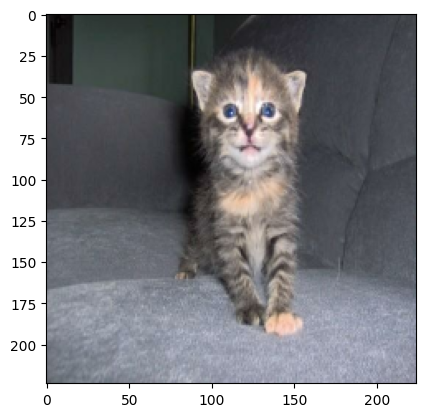

In [6]:
for x, y in train_dataset:
    print(x.shape, y.shape, y)
    image, label = x[0], y[0]
    print(image.shape, label.shape, label)
    # Transpose from (C,H,W) to (H,W,C)
    image = image.transpose(1, 2, 0)
    plt.imshow(image)
    break

As you can see, a label of `0` corresponds to a cat and a `1` corresponds to a dog.

## The Model

We can now start to implement the model. Most parts we already have like `Dropout`, `Conv2d`, `MaxPool2d` and `Linear` layers. We do not however have the `LocalResponseNormalisation` layer. Here's what it does in **simple** terms (in my opinion, the paper massively overcomplicated it):

The goal is to force each filter to learn different features. For example, if all filters learned to recognise vertical lines, then that would be a waste of "brain power". It would be much better to make the filters all learn to recognise different shapes, which would make the model all-around much more robust and performant. This is where `LocalResponseNormalisation` (LRN) comes into play. If neighbouring filters (e.g. filters from 1 to 10) output a high value (i.e. they have found what they were looking for) then those filters have learned to recognise the same thing. We want to penalise this. 

By reducing the output value of a filter X if its neighbouring filters output a similar high number, we **decrease** the overall model performance. Through gradient descent, the model will learn to **avoid** this behaviour. How does it avoid it? By making the filters focus on **different** shapes! That's all it does. Here's the layer implemented in Equinox:

In [7]:
class LocalResponseNormalization(eqx.Module):
    k: int = eqx.field(static=True)
    n: int = eqx.field(static=True)
    alpha: float = eqx.field(static=True)
    beta: float = eqx.field(static=True)

    def __init__(self, k=2, n=5, alpha=1e-4, beta=0.75) -> None:
        self.k = k
        self.n = n
        self.alpha = alpha
        self.beta = beta

    def __call__(self, x: jt.Float[jt.Array, "c h w"]) -> jt.Float[jt.Array, "c h w"]:
        c, _, _ = x.shape
        p = jnp.pad(x, pad_width=[(self.n // 2, self.n // 2), (0, 0), (0, 0)])

        def _body(i):
            window = jax.lax.dynamic_slice_in_dim(p, i, self.n) ** 2
            d = (jnp.einsum("ijk->jk", window) * self.alpha + self.k) ** self.beta
            b = x[i] / d
            return b

        ys = eqx.filter_vmap(_body)(jnp.arange(c))
        return ys

In my honest opinion, this was by far the most complicated part of the paper. The rest is relatively straightforward. This is the entire model:

In [8]:
class AlexNet(eqx.Module):
    conv1: eqx.nn.Conv2d
    conv2: eqx.nn.Conv2d
    conv3: eqx.nn.Conv2d
    conv4: eqx.nn.Conv2d
    conv5: eqx.nn.Conv2d
    lrn1: LocalResponseNormalization
    lrn2: LocalResponseNormalization
    max_pool_1: eqx.nn.MaxPool2d
    max_pool_2: eqx.nn.MaxPool2d
    max_pool_3: eqx.nn.MaxPool2d

    dense1: eqx.nn.Linear
    dense2: eqx.nn.Linear

    dropout1: eqx.nn.Dropout
    dropout2: eqx.nn.Dropout

    final: eqx.nn.Linear

    def __init__(self, *, key: jt.PRNGKeyArray):
        _, *subkeys = jax.random.split(key, 10)
        self.conv1 = eqx.nn.Conv2d(
            in_channels=3,
            out_channels=96,
            kernel_size=11,
            stride=4,
            key=subkeys[0],
        )
        self.conv2 = eqx.nn.Conv2d(
            in_channels=96, out_channels=256, kernel_size=5, stride=1, key=subkeys[1]
        )
        self.conv3 = eqx.nn.Conv2d(
            in_channels=256, out_channels=384, kernel_size=3, stride=1, key=subkeys[2]
        )
        self.conv4 = eqx.nn.Conv2d(
            in_channels=384, out_channels=384, kernel_size=3, stride=1, key=subkeys[3]
        )
        self.conv5 = eqx.nn.Conv2d(
            in_channels=384, out_channels=256, kernel_size=3, stride=1, key=subkeys[4]
        )

        self.lrn1 = LocalResponseNormalization()
        self.lrn2 = LocalResponseNormalization()
        self.max_pool_1 = eqx.nn.MaxPool2d(kernel_size=3, stride=2)
        self.max_pool_2 = eqx.nn.MaxPool2d(kernel_size=3, stride=2)
        self.max_pool_3 = eqx.nn.MaxPool2d(kernel_size=3, stride=2)

        self.dense1 = eqx.nn.Linear(in_features=256, out_features=4096, key=subkeys[5])
        self.dense2 = eqx.nn.Linear(in_features=4096, out_features=4096, key=subkeys[6])

        self.dropout1 = eqx.nn.Dropout()
        self.dropout2 = eqx.nn.Dropout()

        self.final = eqx.nn.Linear(in_features=4096, out_features=1, key=subkeys[7])

    def __call__(
        self, x: jt.Float[jt.Array, "3 224 224"], key: jt.PRNGKeyArray
    ) -> jt.Array:
        key, subkey = jax.random.split(key)
        x = self.conv1(x)
        x = jax.nn.relu(x)
        x = self.lrn1(x)
        x = self.max_pool_1(x)
        x = self.conv2(x)
        x = jax.nn.relu(x)
        x = self.lrn2(x)
        x = self.max_pool_2(x)

        x = self.conv3(x)
        x = jax.nn.relu(x)
        x = self.conv4(x)
        x = jax.nn.relu(x)
        x = self.conv5(x)
        x = jax.nn.relu(x)

        x = self.max_pool_3(x)
        x = jnp.ravel(x)

        x = self.dense1(x)
        x = jax.nn.relu(x)
        x = self.dropout1(x, key=key)
        x = self.dense2(x)
        x = jax.nn.relu(x)
        x = self.dropout2(x, key=subkey)

        x = self.final(x)
        return x

We're getting closer and closer to training our model. We need a few things to track our progress. In the JAX ecosystem, there exist a nice library that can help us called [CommonLoopUtils](https://github.com/google/CommonLoopUtils). CLU is very composable due to its functional nature. Here is one of the simplest ways to interact with it. To get started, we will need a class to hold our metrics:

In [9]:
class TrainMetrics(
    eqx.Module, metrics.Collection
):  # this will make it a dataclass & a CLU metric!
    loss: metrics.Average.from_output("loss")  # pyright: ignore
    accuracy: metrics.Accuracy

We can now initialise our model in the usual way:

In [10]:
train_metrics = TrainMetrics.empty()  # initialise our metrics

alexnet = AlexNet(key=jax.random.key(42))
learning_rate = 0.0001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(eqx.filter(alexnet, eqx.is_array))

It's critical to have an evaluation function to test your model on the `test_dataset` or assess its generalisation performance:

In [11]:
def eval(alexnet: AlexNet, test_dataset, key: jt.PRNGKeyArray) -> TrainMetrics:
    eval_metrics = TrainMetrics.empty()

    for x, y in test_dataset:
        y = y.reshape(-1)  # Make 1D for CLU
        y = jnp.array(y, dtype=jnp.int32)
        key, subkey = jax.random.split(key)
        loss, logits = loss_fn(alexnet, x, y.reshape(-1, 1), subkey)
        logits = jnp.concatenate([-logits, logits], axis=1)
        eval_metrics = eval_metrics.merge(
            TrainMetrics.single_from_model_output(logits=logits, labels=y, loss=loss)
        )

    return eval_metrics

Because our dataset has only 2 classes, we output only a single number, which we apply the Sigmoid function on to get the probability if it's a dog or a cat. We treat any value less than 0.5 to being the 0 output and anything above 0.5 to the 1 class. We can use the `sigmoid_binary_cross_entropy` function from optax for this. 

In [12]:
def loss_fn(
    alexnet: AlexNet,
    x: jt.Float[jt.Array, "batch_size 3 224 224"],
    y: jt.Float[jt.Array, "batch_size 1"],
    key: jt.PRNGKeyArray,
) -> tuple[jt.Array, jt.Array]:
    k, _ = jax.random.split(key)
    logits = eqx.filter_vmap(alexnet, in_axes=(0, None))(x, k)
    loss = optax.sigmoid_binary_cross_entropy(logits, y)
    return jnp.mean(loss), logits
    # we return these logits so we don't have to
    # recompute these later when we measure the accuracy of the model

The last thing before we actually train our model is the `step` function. This is standard JAX/optax code that you should be very familiar with (and if not, burn this into your memory, you'll need it **a lot**):

In [13]:
@eqx.filter_jit
def step(
    alexnet,
    x: jt.Float[jt.Array, "batch_size 3 224 224"],
    y: jt.Float[jt.Array, "batch_size 1"],
    optimizer: optax.GradientTransformation,
    opt_state: optax.OptState,
    key: jt.PRNGKeyArray,
):
    (loss_value, logits), grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(
        alexnet, x, y, key
    )
    updates, opt_state = optimizer.update(grads, opt_state, alexnet)
    alexnet = eqx.apply_updates(alexnet, updates)
    return alexnet, opt_state, loss_value, logits

Great! Now comes the last part: actually training the model. This will take a different amount of time depending on your hardware. Since this is more or less just a small exercise, as soon as you see that the accuracy is over 0.67, you can assume it will keep going up. But until how much? Well, you'll have to discover that on your own!

In [ ]:
key = jax.random.key(99)
n_epochs = 10

for epoch in range(n_epochs):
    batch_count = len(train_dataset)

    pbar = tqdm(enumerate(train_dataset), total=batch_count, desc=f"Epoch {epoch}")
    for i, (x, y) in pbar:
        y = y.reshape(-1, 1)
        y = jnp.array(y, dtype=jnp.int32)
        key, subkey = jax.random.split(key)
        alexnet, opt_state, loss, logits = step(
            alexnet, x, y, optimizer, opt_state, key
        )
        logits = jnp.concatenate([-logits, logits], axis=1)
        train_metrics = train_metrics.merge(
            TrainMetrics.single_from_model_output(
                logits=logits, labels=y.reshape(-1), loss=loss
            )
        )

        vals = (
            train_metrics.compute()
        )  # this will actually compute the metrics based on
        # all the metrics that were inserted with the merge function from above
        pbar.set_postfix(
            {"loss": f"{vals['loss']:.4f}", "acc": f"{vals['accuracy']:.4f}"}
        )

    key, subkey = jax.random.split(key)
    eval_metrics = eval(alexnet, test_dataset, subkey)
    evals = eval_metrics.compute()
    print(
        f"Epoch {epoch}: "
        f"test_loss={evals['loss']:.4f}, "
        f"test_acc={evals['accuracy']:.4f}"
    )

Thanks a lot for checking out this small tutorial and I hope you learned something new!